## Imputation Quality Experiment

In [26]:
from sklearn.decomposition import TruncatedSVD as TSVD, PCA
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd
from collections import Counter
prepared_vectors_doc = './generated/doreco_bert/'
import numpy as np
import dill as pickle

In [12]:
def load_data(doc, min_freq=5):
    df = pd.read_excel('%s/%s_by_lemma.xlsx' % (prepared_vectors_doc, doc), na_filter=False)
    good_trm = {trm for trm, ct in Counter(df.term).items() if ct >= min_freq}
    good_mrk = {mrk for mrk, ct in Counter(df.marker).items() if ct >= min_freq}
    # print(doc, len(good_mrk), len(df), len(np.load('%s/%s_by_lemma.npy' % (prepared_vectors_doc, doc))))
    X = np.load('%s/%s_by_lemma_0.npy' % (prepared_vectors_doc, doc))[df.term.isin(good_trm) & df.marker.isin(good_mrk)]
    df = df[df.term.isin(good_trm) & df.marker.isin(good_mrk)]
    y = np.array([r.marker for i,r in df.iterrows()])
    return df, X, y

In [13]:
def parallelize_crossvalidation(doc, classifier, nfolds = 20, verbose=True):
    df,X,y = load_data(doc, MIN_FREQ)
    accs = np.zeros(len(df))
    
    for i,(tr,ts) in enumerate(KFold(n_splits=min(len(X),nfolds), shuffle=True, random_state=100).split(X), start = 1):
        classifier.fit(X[tr],y[tr])
        y_pred = classifier.predict(X[ts])
        accs[ts] = (y_pred == y[ts])
    df['accuracy'] = accs
    print(doc, np.mean(df['accuracy']))
    return df
    
def get_baseline(doc):
    df = pd.read_excel('./generated/doreco_bert/%s_by_lemma.xlsx' % doc, na_filter=False)
    correct = 0
    for term in df.term.unique():
        c = Counter(df[df.term == term].marker)
        correct += c.most_common(1)[0][1]
    return correct/len(df)

In [20]:
doculects = list(map(lambda x : x.strip(), open('./doreco_english_doculects.txt')))

In [34]:
pickle.dump(dfs[ci], open('./generated/imputation_results/doreco' '_' + str(ci) + '_results.p', 'wb'))

In [39]:
from datetime import datetime
#df_results['accuracy']
MIN_FREQ = 10
R = 0
# with Pool(14) as p:
#     dfs = p.starmap(parallelize_crossvalidation, ((doc, 5, True) for doc in doculects))
#dfs = {}
for ci,classifier in {'knn' : KNeighborsClassifier(n_neighbors=5, weights='distance'),
                      'svc' : SVC(kernel='linear', C = 1, random_state=R),
                      'mlp-100': MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', random_state=R),
                      'mlp' : MLPClassifier(hidden_layer_sizes=(), activation='tanh', random_state=R)}.items():
    #if ci[:3] == 'mlp': continue
    print(ci.upper())
    dfs[ci] = [parallelize_crossvalidation(doc, classifier, 10, True) for doc in doculects]
    pickle.dump(dfs[ci], open('./generated/imputation_results/doreco' '_' + str(ci) + '_results.p', 'wb'))

KNN
anal1239 0.8111808328579578
apah1238 0.8768115942028986
arap1274 0.8523030072325847
bain1259 0.8250950570342205
beja1238 0.8374076179647527
cabe1245 0.8923728813559322
cash1254 0.8907510862818125
dolg1241 0.8836009174311926
even1259 0.8848704038577456
goem1240 0.8690340446326763
goro1270 0.8447142134547294
guri1247 0.8006088280060882
hoch1243 0.843871975019516
jeha1242 0.8709677419354839
jeju1234 0.7963340122199593
kaka1265 0.7800397219463754
kama1351 0.8981327255194179
kark1256 0.8026830631637787
komn1238 0.7926978307363275
ligh1234 0.9370943584623065
movi1243 0.9169632265717675
ngal1292 0.9308510638297872
nngg1234 0.7917897683097497
nort2641 0.891644908616188
nort2875 0.8148387096774193
orko1234 0.8650190114068441
pnar1238 0.891640866873065
port1286 0.8427922814982974
ruul1235 0.8875562218890555
sadu1234 0.7467105263157895
sanz1248 0.9602446483180428
savo1255 0.9312796208530806
sout2856 0.9038295421825511
sumi1235 0.827363184079602
svan1243 0.8641975308641975
taba1259 0.878603945

In [40]:
from matplotlib import pyplot as plt
#
for k in dfs:
    df_global_results = pd.DataFrame({'doculects' : doculects})
    df_global_results['accuracy'] = [dfx.accuracy.mean() for dfx in dfs[k]]
    df_global_results['baseline'] = [get_baseline(doc) for doc in doculects]
    print(k,np.mean(df_global_results.accuracy), np.mean(df_global_results.baseline))
# sns.barplot(data=df_global_results, x='doculects', y='accuracy')
# sns.barplot(data=df_global_results, x='doculects', y='baseline')
# x = plt.xticks(rotation=90)

mlp-100 0.8998730409010046 0.7292712437771551
mlp 0.8983473961414853 0.7292712437771551
knn 0.8624105730325227 0.7292712437771551
svc 0.8901376579667136 0.7292712437771551


In [47]:
a = 0.729
1-(1-0.862)/(1-a)

0.4907749077490775

In [48]:
df_global_results = pd.DataFrame({'doculects' : doculects})
df_global_results['accuracy'] = [dfx.accuracy.mean() for dfx in dfs['mlp-100']]
df_global_results['baseline'] = [get_baseline(doc) for doc in doculects]


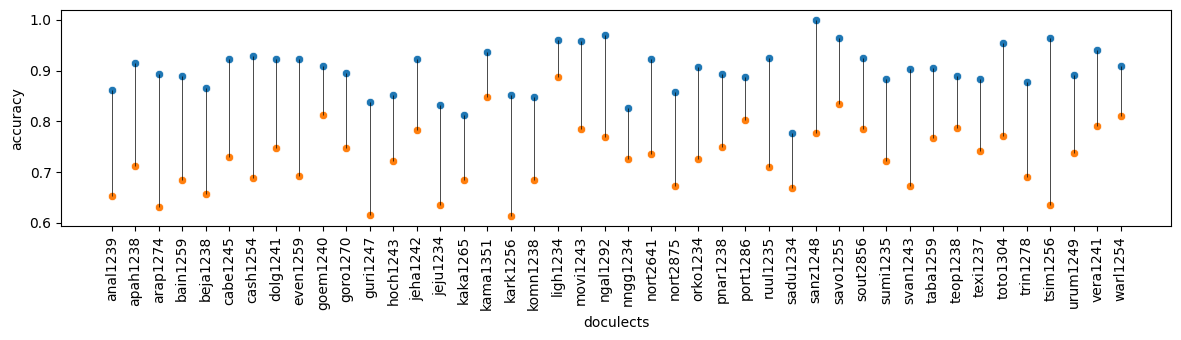

In [51]:
f1 = 'accuracy'
f2 = 'baseline'
plt.figure(figsize=(12,3.5))
sns.scatterplot(data=df_global_results, x='doculects', y=f1)
sns.scatterplot(data=df_global_results, x='doculects', y=f2)
for i in range(len(df_global_results)):
    fmin, fmax = sorted([df_global_results.at[i,f1], df_global_results.at[i,f2]])
    plt.vlines(i, fmin,fmax, color='k', linewidth=0.5)
x = plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('/home/barend/Dropbox/Apps/Overleaf/Inferred Lexification (SigTyp 2025)/latex/figures/%s.png' % f1)

## 5. create imputed dataframe

In [ ]:
def get_offset_ft(corpus, doc, file, line, offset):
    line_fields = line.split('_')
    ln = ('%04d' % (int(line_fields[0]) + offset)) + '_' + '_'.join(line_fields[1:])
    try: return corpus[doc][file][ln]['ft']
    except KeyError: return '' 

imputed_data_builder = []
for doc in corpus:
    print(doc[:4], end =' ')
    df_doc, X, y = load_data(doc)
    df_doc['doculect'] = [doc[:-4]] * len(df_doc)
    Fm, F, Fp, T, G, M = zip(*[(
        get_offset_ft(corpus, doc, file, line, -1), corpus[doc][file][line]['ft'],
        get_offset_ft(corpus, doc, file, line, +1), corpus[doc][file][line]['tx'], 
        ' '.join('.'.join(m['G']) for m in corpus[doc][file][line]['gloss']),
        ' '.join('.'.join(m['M']) for m in corpus[doc][file][line]['gloss']))
                               for file,line in zip(df_doc.file, df_doc.line)])
    df_doc['ft-1'], df_doc['ft'], df_doc['ft+1'] = Fm, F, Fp
    df_doc['tx'], df_doc['gl'], df_doc['mr'] = T, G, M
    imputed_data_builder.append(df_doc)
imputed_data = pd.concat(imputed_data_builder)

In [115]:
imputed_data.sample(30)

,Unnamed: 0,term,doculect,file,line,marker,ft-1,ft,ft+1,tx,gl,mr
968,968,teach,hoch1243,doreco_hoch1243_ED_05,0024_DoReCo_doreco_hoch1243_ED_05,gigus,"I had to do housework, that's the way it is, s...",she taught me a lot of things and I always con...,"I'm not supposed to mess my life up, that's wh...",hegų wažąra roohąxjį hįgigųsregi heesge...,that.way something.NMLZ a.lot.INTS 1E.U.teach....,hegų wažą.=ra roohą.=xjį hį-.gigųs.=reg...
5710,5710,turn,sout3282,doreco_sout3282_mc_english_kent02_b,0043_DoReCo_doreco_sout3282_mc_english_kent02_b,^turn,Yes.,"Oh, yes, we used to turn them out.",,oh yes we used to turn them out,,
537,537,water,movi1243,doreco_movi1243_EAO-vibora,0138_DoReCo_doreco_movi1243_EAO-vibora,:mi,I took one sppon and,I mixed it so that warmed up... in the water a...,three drips of that...,ala:kwa bo oj veyo'niwa'is nij to:mi che jayna...,mix REAS ART.N.PST warm.PRC.NMZ.3PL.AB water ...,ala:kwa bo os veyo'.-ni.-wa.=is to:mi che ye...
1871,1871,rat,nisv1234,doreco_nisv1234_T5_15-12-2013_Levetbao_Aven_Nh...,0017_DoReCo_doreco_nisv1234_T5_15-12-2013_Leve...,hasu$,Then they go and...,"They go, the rat has already climbed into the ...","He eats away at the falling papaya, the bird l...",ara=van nhasu a=sah nabrav_sabat moq-i,3pl.go rat 3SG.climb breadfruit Asp.f.Intruder,"ara.van, nhasu a.sah nabrav_sabat moq.i."
1536,1536,go,beja1238,doreco_beja1238_BEJ_MV_NARR_56_dove,0005_DoReCo_doreco_beja1238_BEJ_MV_NARR_56_dove,gi:g,to her children:,when she was going,this sorghum is ripe,giːgtihoːb oːdoːr,leave.AOR.3SG.F.when DEF.SG.M.ACC.time,giːg.-ti.=hoːb oː=.doːr
2163,2163,leave,goem1240,doreco_goem1240_Kur,0089_DoReCo_doreco_goem1240_Kur,^nyet$,Everybody removed his feather. Okay.,They left the tortoise (and he) lay there.,"They just rose (and) descended, then onto the ...",m�ep nyet k'ur t'o d'i,3Pl.S leave tortoise lie LOC.ANAPH,m�ep nyet k'ur t'o d'i
6858,6858,today,sout3282,doreco_sout3282_mc_english_devon01,0107_DoReCo_doreco_sout3282_mc_english_devon01,^today$,,"Well, that's what makes you feel sorry for the...",,well that's what makes you feel sorry for thes...,,
6596,6596,sister,sout3282,doreco_sout3282_mc_english_london01_b,0052_DoReCo_doreco_sout3282_mc_english_london...,^sister,,"Yeah. Anyway, we're in Stamps', there's Bobby ...",,yeah anyway we're in stamps there's bobby stam...,,
2479,2479,man,texi1237,doreco_texi1237_LaMujerFloja,0114_DoReCo_doreco_texi1237_LaMujerFloja,^paan,He started feeding him.,"The man finished eating, everything",and [also] the woman . They already ate both.,maʔye wiʔk jepeʔ pääñ byumbe,PFV.already eat this man 3.A.all,"ma'.-ye wê'k jepe' pääñ, y-.bumbe"
1612,1612,many,orko1234,doreco_orko1234_ET1_2,0036_DoReCo_doreco_orko1234_ET1_2,^mele$,"the wind was really strong, it made",it hit many trees,,tesie liē yēl tee lon mēle nga bur,3SG.NREC.PST.hit tree 3PL 3SG.NREC.PST,te=.sie liē yēl te=


In [28]:
ft_per_m = {}
for doci in corpus:
    print('load ft_per_m for %s' % doci[:-4])
    dfi, Xi, yi = load_data(doci)
    ft_per_m[doci] = {}
    for marker in dfi.marker.unique():
        ft_per_m[doci][marker] = set(dfi[dfi.marker == marker].term.unique())

NameError: name 'corpus' is not defined

In [143]:
def parallelize_imputation(doci):
    classifier = pickle.load(open('%s/model_%s.p' % (te_folder, doci[:-4]), 'rb'))
    dfi, Xi, yi = load_data(doci)
    ft_doci = set(dfi.term.unique())
    #
    imputed_terms, ft_present = [],[]
    for docj in corpus:
        print('  %s -- %s' % (doci[:-4], docj[:-4]), datetime.now())
        if docj == doci: 
            imputed_terms.extend(yi)
            ft_present.extend([True]*len(yi))
        else:
            dfj, Xj, yj = load_data(docj)
            y_pred = classifier.predict(Xj)
            imputed_terms.extend(y_pred)
            ft_present.extend([ft_per_m[docj][marker] & ft_doci != set() for marker in dfj.marker])
    #imputed_data['imputed_%s' % doci[:-4]] = imputed_terms
    #imputed_data['ft_present_%s' % doci[:-4]] = ft_present
    print(doci, len(imputed_terms), len(ft_present))
    return imputed_terms, ft_present

In [144]:
from multiprocessing import Pool
with Pool(14) as p:
    results = p.map(parallelize_imputation, sorted(corpus))

  cabe1245 -- anal1239 2024-03-22 17:23:49.999991
  hoch1243 -- anal1239 2024-03-22 17:23:50.214624
  bain1259 -- anal1239 2024-03-22 17:23:50.293642
  goro1270 -- anal1239 2024-03-22 17:23:50.313986
  apah1238 -- anal1239 2024-03-22 17:23:50.445309
  jeha1242 -- anal1239 2024-03-22 17:23:50.505567
  anal1239 -- anal1239 2024-03-22 17:23:50.679473
  anal1239 -- apah1238 2024-03-22 17:23:50.690568
  even1259 -- anal1239 2024-03-22 17:23:50.956524
  cash1254 -- anal1239 2024-03-22 17:23:51.003436
  goem1240 -- anal1239 2024-03-22 17:23:51.219537
  arap1274 -- anal1239 2024-03-22 17:23:51.321563
  beja1238 -- anal1239 2024-03-22 17:23:51.353693
  cabe1245 -- apah1238 2024-03-22 17:23:51.523189
  dolg1241 -- anal1239 2024-03-22 17:23:51.616302
  bora1263 -- anal1239 2024-03-22 17:23:52.284707
  cabe1245 -- arap1274 2024-03-22 17:23:52.531464
  bain1259 -- apah1238 2024-03-22 17:23:53.833830
  cabe1245 -- bain1259 2024-03-22 17:23:54.002655
  goro1270 -- apah1238 2024-03-22 17:23:54.328346


In [145]:
for doc,(it,ft) in zip(sorted(corpus),results):
    imputed_data['imputed_%s' % doc[:-4]] = it
    imputed_data['ft_present_%s' % doc[:-4]] = ft

In [146]:
imputed_data.to_excel('%s/imputed_data.xlsx' % (te_folder))

In [147]:
imputed_data.columns

Index(['Unnamed: 0', 'term', 'doculect', 'file', 'line', 'marker', 'ft-1',
       'ft', 'ft+1', 'tx',
       ...
       'imputed_tsim1256', 'ft_present_tsim1256', 'imputed_urum1249',
       'ft_present_urum1249', 'imputed_vera1241', 'ft_present_vera1241',
       'imputed_yong1270', 'ft_present_yong1270', 'imputed_yuca1254',
       'ft_present_yuca1254'],
      dtype='object', length=106)

In [148]:
imputed_data.sample(10)

,Unnamed: 0,term,doculect,file,line,marker,ft-1,ft,ft+1,tx,...,imputed_tsim1256,ft_present_tsim1256,imputed_urum1249,ft_present_urum1249,imputed_vera1241,ft_present_vera1241,imputed_yong1270,ft_present_yong1270,imputed_yuca1254,ft_present_yuca1254
2240,2240,find,beja1238,doreco_beja1238_BEJ_MV_NARR_17_shoemaker,0105_DoReCo_doreco_beja1238_BEJ_MV_NARR_17_sho...,sin,"I put them down,","every morning I found them sewn.""","when he says : "" All the people come and buy t...",faʤilka amheːjda isinneːb,...,hit$,False,^gatir,True,^sier$,True,^sidzi-thaeqo$,False,^taas,False
6328,6328,judge,beja1238,doreco_beja1238_BEJ_MV_NARR_14_sijadok,0052_DoReCo_doreco_beja1238_BEJ_MV_NARR_14_sij...,^iga:d,She went back to her daughters and,"""The judge told me these words,",until tomorrow,igaːd eːn jʔadim idheːb,...,ng'ad,False,^girih_sirigi$,False,^'ama,False,^thv-v<dzo>[-ki$,False,^geerra$,False
2285,2285,say,kama1351,doreco_kama1351_PKZ_196X_SU0215,0130_DoReCo_doreco_kama1351_PKZ_196X_SU0215,^ma,"My mother started cooking meat, feed them.",And I say: to go or not to go?,"""If you want, go, if you don't want, don't go.",a măn mălliam: kanzittə ilʼi ej kanzittə,...,ey,True,^dii,True,^tek$,True,w-tsw$,True,ya'al,True
1228,1228,girl,kark1256,doreco_kark1256_D13GAKFarming,0246_DoReCo_doreco_kark1256_D13GAKFarming,^tee,yes and that is what is called,"when they betroth you a girl, the day you agre...",for example today,ma t̪ɛɛr ʊʊ t̪ɔmbʊlnʊʊl ma t̪ɛɛr i̠ŋgɪl ʊ t̪ɔd...,...,^hu,True,^giz,True,^rene,True,^mvzo,True,^taankelemo'ono$,False
17875,17875,hard,kama1351,doreco_kama1351_PKZ_196X_SU0210,0042_DoReCo_doreco_kama1351_PKZ_196X_SU0210,^sedem$,"Today I'm not working, I'm speaking with you.","Although it's not hard, I'm very tired.",It rains hard.,xotʼ ej sedem a tararluʔpiem ugandə,...,bur,False,^catin,True,^babarak$,True,^sidzi-thaeqo$,True,^meyaj,False
311,311,go,sout3282,doreco_sout3282_mc_english_kent01,0049_DoReCo_doreco_sout3282_mc_english_kent01,^going$,,"So, as I was going in Ashford Market I'd been ...",,so as i was going in ashford market i'd been w...,...,gaw,True,^gid,True,^van,True,bi,True,^kana,False
9097,9097,buy,kama1351,doreco_kama1351_PKZ_196X_SU0224,0153_DoReCo_doreco_kama1351_PKZ_196X_SU0224,^ibi?i$,"He went into the house, they went into the hou...","She lived very well, they bought all sort of t...","Then they bought her boots, [they are] beautif...",bar ugandə noise dĭʔnə jakše molambi ešši ge b...,...,kwal,False,^kas,False,^babarak$,False,^sidzi-thaeqo$,False,^yuum,False
5657,5657,stay,beja1238,doreco_beja1238_BEJ_MV_NARR_25_ORPHAN,0169_DoReCo_doreco_beja1238_BEJ_MV_NARR_25_ORPHAN,:st?,He said : ' No way! I am not a man who runs aw...,"he stays, they said.",The snake was coming and,eːstʔeː eːn,...,afta,True,^dur,True,'og,True,^le-zi-,False,^kux,False
214,214,say,bora1263,doreco_bora1263_mc_bora_ajyuwa,0013_DoReCo_doreco_bora1263_mc_bora_ajyuwa,^ne,"That is why, one day she told her daughter "" A...","But she said "" Yes, I do not know who comes to...",,árónáa neélle éée tsá o wáájácutú múha pejco t...,...,^gway$,True,^dedi,True,^so$,True,^pi,True,^ki,True
1760,1760,see,komn1238,doreco_komn1238_tci20130823a-08,0034_DoReCo_doreco_komn1238_tci20130823a-08,.ma.r,they will come here,they saw alen,his uncles,ʔa.len sa.ma.rath,...,^qada,True,^gor,True,'en$,True,do,True,^taas,False


In [ ]:
term_extensions = defaultdict(lambda : {})
for c,m in imputed_values.items():
    for l in m.columns[1:]:
        for t in m[l].unique():
            if isinstance(t,str):
                term_extensions[l,t][c] = m[l] == t

In [ ]:
for l,t in list(term_extensions):
    polyseme_graph = nx.Graph()
    polyseme_graph.add_nodes_from(term_extensions[l,t].keys())
    for e1,e2 in combinations(sorted(term_extensions[l,t]),2):
        if len(colexification_pairs[e1,e2]) > 1:
            polyseme_graph.add_edge(e1,e2)
    if nx.number_connected_components(polyseme_graph) == 1: continue
    for ci,c in enumerate(nx.connected_components(polyseme_graph)):
        for cx in c:
            term_extensions[l,t + '-' + str(ci+1)][cx] = term_extensions[l,t][cx]
    del term_extensions[l,t]
            

In [ ]:
print(len(term_extensionstensions))

In [ ]:
np.set_printoptions(precision=2)
strip_index = lambda k : k.split('-')[0]
model = {}
for l,t in sorted(term_extensions):
    df = pd.concat([imputed_values[c][term_extensions[l,t][c]] for c in term_extensions[l,t]])
    #if len(term_extensions[l,t]) == 1: continue
    df_long = short_to_long(df[df.columns[1:]]) 
    try:
        model[l,t] = {'pca' : PCA()}
        model[l,t]['coo'] = model[l,t]['pca'].fit_transform(df_long.to_numpy())
        good_pc = next((i for i,e in enumerate(model[l,t]['pca'].explained_variance_) if e < 1),0)
        if good_pc == 0:
            del model[l,t]
            continue
        model[l,t]['coo'] = model[l,t]['coo'][:,:max(2,good_pc)]
        print(l,t,list(term_extensions[l,t]), len(df), good_pc)
    except: continue
pickle.dump(model, open('pca_models.p','wb'))

In [ ]:
print(len(model))
print(Counter([sum(v['pca'].explained_variance_ >= 1) for v in model.values()]))

In [ ]:
corpus_size = {d : sum(len(ei) for ei in bitexts[d][1]) for d in bitexts}

In [ ]:
conc_data = pd.read_excel('../metaphor/bert_exploration/13428_2013_403_MOESM1_ESM.xlsx')
conc_dict = {r.Word : r['Conc.M'] for i,r in conc_data.iterrows()}

In [ ]:
def colex(coo_h, terms_h, k=3):
    ordered = coo_h.argsort()
    return int(Counter(terms_h[ordered[:k]]).most_common(1)[0][0] == 
               Counter(terms_h[ordered[len(ordered)-k:]]).most_common(1)[0][0])

In [ ]:
builder = []
for (l,t) in sorted(model):
    terms = [k for k in term_extensions[l,t].keys()]
    conc_score = np.mean([conc_dict[term[:-2]] for term in terms if term[:-2] in conc_dict])
    coo, pca = model[l,t]['coo'], model[l,t]['pca']
    df_orig = pd.concat([original_values[term][term_extensions[l,t][term]] for term in terms])
    df_imput = pd.concat([imputed_values[term][term_extensions[l,t][term]] for term in terms])
    print(l,t,terms,conc_score, len(df_imput))
    coo_scaled = MinMaxScaler(feature_range=(-1,1)).fit_transform(coo)
    n_good_dims = sum(pca.explained_variance_ >= 1)
    #print(l.upper(), t.upper(), '\t', n_good_dims, pca.explained_variance_[:5], pca.explained_variance_ratio_[:5])
    good_docs = [d for d,v in df_orig.value_counts('doculect').items() if v >= 10]
    wpms = {d : np.log(1e6*sum(df_orig.doculect==d)/corpus_size[d]) for d in good_docs}
    wpm_m, wpm_s = np.mean(list(wpms.values())), np.std(list(wpms.values()))
    #
    for dim in range(n_good_dims):
        hits = {d : (df_orig.doculect==d).to_numpy() for d in good_docs}
        good_docs_d = [d for d in good_docs if sum(coo[hits[d],dim] < 0) > 0 and sum(coo[hits[d],dim] > 0) > 0]
        #skew_dir = -1 if skew(coo[:,dim]) < 0 else 1
        #mean_dir = -1 if np.mean(np.mean(coo[df.doculect==d,dim]) for d in good_docs_d) < 0 else 1
        
        print('  DIM %d: N bad docs = %d, N good docs = %d' % 
              (dim, len(good_docs)-len(good_docs_d), len(good_docs_d)))
        indeps = {}
#         indeps['spread_mean'] = { d : abs(np.mean(coo_scaled[hits[d],dim])) for d in good_docs_d}
        indeps['spread_sd'] = { d : np.std(coo_scaled[hits[d],dim]) for d in good_docs_d }
#         indeps['spread_skew'] = { d : abs(skew(coo[hits[d],dim])) for d in good_docs_d }
#         indeps['spread_kurtosis'] = { d : kurtosis(coo[hits[d],dim]) for d in good_docs_d }
        #
        ms = {k : (np.mean(list(v.values())), np.std(list(v.values()))) for k,v in indeps.items()}
        
        for doc in sorted(good_docs_d):
            h = (df_orig.doculect==doc).to_numpy()
            if len(df_orig[h].term.unique()) == 1: IG, IGR = 0, 0
            else:
                d = DecisionTreeClassifier(max_depth=1,criterion="entropy")
                d.fit(coo[h,dim].reshape(-1,1), df_orig[h].term)
                H_start = d.tree_.impurity[0]
                p_left = sum(coo[h,dim] < d.tree_.threshold[0])/sum(h)
                H_new = (p_left * d.tree_.impurity[1]) + ((1-p_left) * d.tree_.impurity[2])
                IG = H_start - H_new
                IGR = IG/H_start
            #            
            builder.append({'term' : t, 'orig_doculect' : l,
                            'doculect' : doc, 'PC' : dim, 'IG' : IG, 'IGR' : IGR,
                            'nTermTypes' : len(df_orig[h].term.unique()), 'nTermTokens' : sum(h),
                            'nFieldTypes' : len(terms),
                            'wpm' : wpms[doc], 'wpm_z' : (wpms[doc]-wpm_m)/wpm_s,
                            'concreteness' : conc_score, 'ev' : pca.explained_variance_[dim],
                            'colexifies_1' : colex(coo[h,dim], df_orig[h].term.to_numpy(), k=1),
                            'colexifies_3' : colex(coo[h,dim], df_orig[h].term.to_numpy(), k=3),
                            'colexifies_5' : colex(coo[h,dim], df_orig[h].term.to_numpy(), k=5)})
            for k in indeps:
                builder[-1][k] = indeps[k][doc]#(indeps[k][doc]-ms[k][0])/ms[k][1]

In [ ]:
from scipy.stats import pearsonr
from itertools import product
from scipy.stats.mstats import zscore

import statsmodels.api as sm
from statsmodels.formula.api import ols, logit
from statsmodels.graphics.api import interaction_plot, abline_plot

In [ ]:
X = [ 'spread_sd', 'wpm', 'concreteness']
Y = ['IG','colexifies_3']
df_result = pd.DataFrame(builder)
for v in X+Y[:1]: df_result[v] = zscore(df_result[v])

In [ ]:
sns.heatmap(df_result[X].corr(), cmap='vlag', vmin=-1, vmax=1, annot=True);

In [ ]:
dfi = df_result#[df_result.nFieldTypes>1]
y = 'colexifies_3'
print(dfi.value_counts(y))
lm = logit('%s ~  spread_sd + wpm + concreteness' % y, dfi).fit()
print(lm.summary())

In [ ]:
# manual example of dealing with odds ratios
sd = 0
z = -0.2 + (sd * -0.59) #+ (sk * 1.06)
p = 1 / (1 + np.exp(-z))
print(p)

In [ ]:
from scipy.stats import ttest_ind
dataslices = {'all' : df_result, 
              'pc0' : df_result[df_result.PC == 0]}
y = 'colexifies_3'
for x in X + ['nFieldTypes']:
    for k,dfi in dataslices.items():
        t,p = ttest_ind(dfi[dfi[y]==0][x], dfi[dfi[y]==1][x])
        print('%s~%s for %s: t=%.3f, p=%.3f' % (y,x,k, t,p))
        sns.boxplot(data=dfi, x = y, y = x)
        plt.show()

In [ ]:
dfi = df_result
lm = ols('IG ~ spread_sd + wpm + concreteness', dfi).fit()
print(lm.summary())

In [ ]:
dataslices = {'all' : df_result, 
              'pc0' : df_result[df_result.PC == 0], 'pc+' : df_result[df_result.PC != 0]}
y = 'IG'
for x in X + ['nFieldTypes']:
    for k,dfi in dataslices.items():
        if k != 'all': continue
        r,p = pearsonr(dfi[x], dfi[y])
        print('%s~%s for %s: r=%.3f, p=%.3f' % (y,x,k, r,p))
        sns.regplot(data=dfi, x = x, y = y, scatter_kws={'s':10,'color':'#606060'}, line_kws={'lw':3,'color':'r'})
        plt.show()

In [ ]:
for (l,t) in model:
    terms = [k for k in term_extensions[l,t].keys()]
    conc_score = np.mean([conc_dict[term[:-2]] for term in terms if term[:-2] in conc_dict])
    coo, pca = model[l,t]['coo'], model[l,t]['pca']
    df_orig = pd.concat([original_values[term][term_extensions[l,t][term]] for term in terms])
    df_imput = pd.concat([imputed_values[term][term_extensions[l,t][term]] for term in terms])
    print(l,t,terms,conc_score, len(df_imput))
    coo, pca = model[l,t]['coo'], model[l,t]['pca']
    n_good_dims = sum(pca.explained_variance_ >= 1)
    good_docs = [d for d,v in Counter(dict(df_orig.value_counts('doculect'))).items() if v >= 10]
    #
    nrows = max(1,(len(good_docs)+3)//4)
    for dim in range(n_good_dims):
        print('\t', dim)
        plt.figure(figsize=(35,8*nrows))
        fig, axs = plt.subplots(nrows=nrows, ncols=4, squeeze=False, sharex=True, sharey=True, figsize=(30,7*nrows))
        #fig.title('%s; PC%d' % (ts, dim+1))
        hits = {d : (df_orig.doculect==d).to_numpy() for d in good_docs}
        good_docs_d = [d for d in good_docs if sum(coo[hits[d],dim] < 0) > 0 and sum(coo[hits[d],dim] > 0) > 0]
        #
        for i,doc in enumerate(good_docs):
            b = next((b for b in builder if b['term'] == t and b['orig_doculect'] == l and b['doculect'] == doc),None)
            h = (df_orig.doculect==doc).to_numpy()
            if sum(h) == 0: continue
            tcs = ' '.join('%s (%d)' % x for x in 
                           Counter(dict(df_orig[h].value_counts('term').items())).most_common(3))
            
            sns.scatterplot(x=coo[h,dim], y=coo[h,(1 if dim == 0 else 0)], hue=df_orig[h]['term'], ax=axs[i//4,i%4]) 
            axs[i//4,i%4].legend(fontsize=20)
            try: axs[i//4,i%4].set_title('%s; good=%d; C=%d; SD=%.2f; WM=%.2f' % 
                                    (doc, doc in good_docs_d, b['colexifies_3'], b['spread_sd'], b['wpm']))
            except: axs[i//4,i%4].set_title('%s; good=%d' % (doc, doc in good_docs_d))
        if not os.path.isdir('figures/%s/' % '-'.join(c[:-2] for c in terms)):
            os.mkdir('figures/%s/' % '-'.join(c[:-2] for c in terms))
        plt.savefig('figures/%s/%s_%s_%d.jpeg' % 
                    ('-'.join(c[:-2] for c in terms), l[:-4], t, dim+1), transparent=False)
        plt.clf()

even1259.csv ^wa ['kill_l'] 3.9 806
	 0
even1259.csv alij$ ['small_l'] 3.22 85
	 0
even1259.csv b@j@ ['man_l', 'people_l', 'person_l'] 4.776666666666666 3945
	 0
	 1
even1259.csv har@ ['know_l'] 1.68 1491
	 0
even1259.csv kann ['young_l'] 3.16 19
	 0
even1259.csv ll-1 ['tell_l'] 2.9 676
	 0
	 1
even1259.csv mon ['leave_l'] 2.53 56
	 0
even1259.csv nganis ['old_l'] 2.72 47
	 0
even1259.csv nguk ['ask_l'] 2.52 471
	 0
even1259.csv rgani ['day_l'] 3.92 972
	 0
even1259.csv tirk-1 ['old_l'] 2.72 395
	 0
even1259.csv up ['take_l'] 3.06 301
	 0
	 1
even1259.csv uru ['go_l', 'take_l', 'leave_l'] 2.9133333333333336 4158
	 0
	 1
even1259.csv wun@ ['make_l'] 2.67 227
	 0
goem1240.csv ^an$ ['think_l'] 2.41 573
	 0
	 1
goem1240.csv ^b'en$ ['look_l'] 2.96 49
	 0
goem1240.csv ^bi$ ['thing_l', 'way_l'] 2.755 1034
	 0
	 1
goem1240.csv ^doe$ ['come_l'] 2.72 4313
	 0
goem1240.csv ^gurum$ ['man_l', 'person_l'] 4.755 753
	 0
goem1240.csv ^jap$ ['child_l'] 4.78 1604
	 0
	 1
goem1240.csv ^mang$ ['take_l'] 3

kama1351.csv ^so ['come_l'] 2.72 4313
	 0
kama1351.csv ^surar ['ask_l'] 2.52 471
	 0
kama1351.csv ^ten ['think_l'] 2.41 573
	 0
	 1
kama1351.csv ^timn ['know_l'] 1.68 1499
	 0
kama1351.csv ^tur ['house_l'] 5.0 1268
	 0
kama1351.csv abi ['do_l', 'make_l'] 2.565 787
	 0
	 1
kama1351.csv akt@$ ['old_l'] 2.72 110
	 0
kama1351.csv bu-1 ['person_l', 'man_l'] 4.755 1696
	 0
kama1351.csv bu-2 ['river_l', 'water_l'] 4.945 930
	 0
kama1351.csv d'abakt@r ['talk_l', 'speak_l'] 3.8850000000000002 1058
	 0
kama1351.csv d'u-1 ['little_l', 'small_l'] 3.4450000000000003 690
	 0
kama1351.csv dava ['start_l', 'begin_l'] 2.635 649
	 0
kama1351.csv kola ['fish_l', 'dry_l'] 4.385 538
	 0
	 1
kama1351.csv kubi ['see_l', 'find_l'] 2.92 2250
	 0
	 1
kama1351.csv lunk ['hole_l'] 4.81 17
	 0
kama1351.csv ma: ['leave_l'] 2.53 322
	 0
kama1351.csv star ['old_l'] 2.72 831
	 0
kama1351.csv t'i ['way_l', 'road_l'] 3.545 356
	 0
kama1351.csv tibi ['man_l', 'marry_l', 'husband_l'] 3.9766666666666666 713
	 0
	 1
	 2
kam

In [ ]:
for (l,t) in model:
    terms = [k for k in term_extensions[l,t].keys()]
    conc_score = np.mean([conc_dict[term[:-2]] for term in terms if term[:-2] in conc_dict])
    coo, pca = model[l,t]['coo'], model[l,t]['pca']
    df_orig = pd.concat([original_values[term][term_extensions[l,t][term]] for term in terms])
    df_imput = pd.concat([imputed_values[term][term_extensions[l,t][term]] for term in terms])
    print(l,t,terms,conc_score, len(df_imput))
    coo, pca = model[l,t]['coo'], model[l,t]['pca']
    n_good_dims = sum(pca.explained_variance_ >= 1)
    good_docs = [d for d,v in Counter(dict(df_orig.value_counts('doculect'))).items() if v >= 10]
    #
    wpms = {d : np.log(1e6*sum(df.doculect==d)/corpus_size[d]) for d in good_docs}
    wpm_m, wpm_s = np.mean(list(wpms.values())), np.mean(list(wpms.values()))
    #
    character = {}
    for dim in range(n_good_dims):
        hits = {d : (df.doculect==d).to_numpy() for d in good_docs}
        good_docs_d = [d for d in good_docs if sum(coo[hits[d],dim] < 0) > 0 and sum(coo[hits[d],dim] > 0) > 0]
        dimmin, dimmax = (coo[:, dim].min(),coo[:,dim].max())
        labels = np.array(['0', '-', '+'])
        character['PC%d' % dim] = labels[(coo[:,dim] < dimmin + (1 * (dimmax-dimmin)/4)).astype(int) + 
                                         2*(coo[:,dim] > dimmin + (3 * (dimmax-dimmin)/4)).astype(int)]
    
    df_t = pd.DataFrame(character)
    builder_r = []
    for i,r in df_orig.iterrows():
        builder_r.append({x : ' '.join(map(lambda x : (x if isinstance(x,str) else '.'.join(x)),
                                           corpus[r.doculect][r.file][r.line][x]))
                          for x in ['wr', 'mr', 'gl']})
        builder_r[-1]['ft'] = corpus[r.doculect][r.file][r.line]['ft'
                                                                ]
        builder_r[-1]['i'] = i
        builder_r[-1]['doculect'] = r.doculect
        builder_r[-1]['file'] = r.file
        builder_r[-1]['line'] = r.line
    df_t = pd.concat([df_t, pd.DataFrame(builder_r)], axis=1)
    df_t.to_excel('./data/hits/%s.xlsx' % ts)

In [ ]:
dimmin

In [ ]:
(coo[:,dim] < (dimmin + (1 * (dimmax-dimmin)/4))).astype(int)[:90],2* (coo[:,dim] > (dimmin + (3 * (dimmax-dimmin)/4))).astype(int)[:90]
    

In [ ]:
# c = 'say_l'
# m = imputed_values[c]
# ct = Counter()
# for i,r in enumerate(m.to_numpy()):
#     key = ' '.join(map(lambda x : x[:3], r[1:]))
#     ct[key] += 1

# ct.most_common()

In [ ]:
# # compile sparse matrix
# st = datetime.now()
# from scipy.sparse import csc_matrix, csr_matrix
# #
# graphs = {}
# for c in good_concepts[::-1]:
#     if c != 'land_l': continue
#     lab_indices = {}
#     sit_indices = {}
#     rows, cols = [], []
#     m = imputed_values[c]
#     m_unique = {}
#     for i,r in enumerate(m.to_numpy()):
#         key = tuple([(ci,ri) for ci,ri in zip(m.columns[1:], r[1:])])
#         m_unique[key] = m_unique.get(key, []) + [i]
#     for k,V in m_unique.items():
#         csc_i = sit_indices[c,k] = len(sit_indices)
#         for ci,ri in k:
#             try: lab_i = lab_indices[ci,ri]
#             except KeyError: lab_i = lab_indices[ci,ri] = len(lab_indices)
#             rows.append(csc_i); cols.append(lab_i)
#     m_csr = csc_matrix(((np.ones(len(rows)), (cols, rows))))
#     print(c, m_csr.shape)
#     V, E, Ew = build_semantic_map(m_csr)
#     print(c, len(V), len(E))


In [ ]:
# neighbouring_fields = for c in good_concepts:
#     pos = [i for k,i in sit_indices.items() if k[0] == c]
#     neg = [i for k,i in sit_indices.items() if k[0] != c]
#     endo = int(m_csrx[pos].dot(m_csrx[pos].T).min())
#     exo = int(m_csrx[pos].dot(m_csrx[neg].T).max())
#     print(c, endo, exo)
#     if endo < exo:
#         exo_hits = set((m_csrx[pos].dot(m_csrx[neg].T) > max(endo,1)).nonzero()[1])
#         exo_concepts = {c for (c,ti),i in sit_indices.items() if i in exo_hits}
#         field_mergers.add_edges_from((c,e) for e in exo_concepts)
#         print(exo_concepts)
#     exo_hits = set((m_csrx[pos].dot(m_csrx[neg].T) > 1).nonzero()[1])
#     exo_concepts = {c for (c,ti),i in sit_indices.items() if i in exo_hits}
#     print('!', exo_concepts)

In [ ]:
# for c in list(nx.connected_components(field_mergers))[::-1]:
#     pos = [i for k,i in sit_indices.items() if k[0] in c]
#     print(c, len(pos))
#     m_csr_c = m_csr[:,pos]
#     print(m_csr_c.shape)
#     #V, E, Ew = build_semantic_map(m_csr_c)

In [ ]:
# def C(constraints, E):
#     cost = 0
#     for S in constraints:
#         cost += (1-ncc(set(S.nonzero()[1]), E) if S.nnz > 0 else 0)
#     return cost

# def ncc(S, E):
#     cc = 0
#     explored = set()
#     for v in S:
#         if v in explored: continue
#         else: cc += 1
            
#         frontier = [v]
#         while len(frontier) > 0:
#             u = frontier.pop()
#             if u in explored: continue
#             explored.add(u)
#             if u not in E: continue
#             frontier.extend(list(S.intersection(E[u])))
#     #print('\t',S, E, cc)

#     return cc

# def find_edges(constraints):
#     # determine possible edges
#     x = constraints.T.dot(constraints)
#     x2 = (x > 1)
#     V2c = Counter()
#     for i in range(x2.shape[1]):
#         for j in x2[:i,i].nonzero()[0]:
#             V2c[i,j] = x[i,j]
#     V2 = set(V2c)
#     print('n edges', len(V2))
#     # initialize edges and weight
#     E = { i : set() for i in np.arange(x.shape[0])}
#     E_weight = {}
#     #
#     total_cost = C(constraints, E)
#     last_best_decrease = max(V2c.values())
#     E_prev = { i : set() for i in np.arange(x.shape[0])}
#     last_scores = {}
#     while total_cost < 0:
#         best_decrease = 0
#         best_edge = (None, None)
#         for i,(u,v) in enumerate(list(V2)):
#             if i % 500 == 0: print('\t', i, len(V2), best_decrease, best_edge)
#             E[u].add(v)
#             E[v].add(u)
#             c = last_scores[u,v] = C(constraints, E)
#             E[u].remove(v)
#             E[v].remove(u)
#             new_decrease = c - total_cost
#             #print('\t\ttry', u,v, '\t', c, total_cost, new_decrease)
#             if new_decrease > best_decrease:
#                 best_decrease = new_decrease
#                 best_edge = (u,v)
#                 if best_decrease == last_best_decrease:
#                     break
#             if new_decrease == 0: V2.remove((u,v))

#         u,v = best_edge
#         print('\t',u,v,best_decrease, total_cost+best_decrease)
#         E[u].add(v)
#         E[v].add(u)
#         V2.remove((u,v))
#         E_weight[u,v] = E_weight[v,u] = best_decrease
#         total_cost += best_decrease
#         last_best_decrease = best_decrease
#         E_prev = {k : v.copy() for k,v in E.items()}
#     return E, E_weight

# def build_semantic_map(constraints):
#     E, E_weight = find_edges(constraints)
    
#     best_edges = []
#     for u in E:
#         best_edges.extend([tuple(sorted((u,v))) for v in E[u]])
#     return (set(range(constraints.shape[0])), set(best_edges), E_weight)

# def show_graph(V, E, E_weight, pos = None, outfile=None):
#     plt.figure(figsize=(20,20))
#     label_dict = {i : v for i,v in enumerate(V)}
#     gr = nx.Graph()
#     gr.add_nodes_from(np.arange(len(V)))
#     gr.add_edges_from(E)
#     if pos == None:
#         pos = nx.spring_layout(gr, k=0.30,iterations=20)
#     nx.draw(gr, pos, labels=label_dict, node_size=1500, node_color='w', font_size=15, with_labels=True)
#     if outfile is None: plt.show()